In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import folium
from folium.plugins import HeatMap
import datetime
import os

# Get the absolute path to this working directory
cheminAbs = os.getcwd().split(os.path.sep)

# Change the path to the directory CSV
cheminAbs[len(cheminAbs)-1] = "CSV"
chemin = os.path.sep.join(cheminAbs)

# Load the data
df_incidents = pd.read_csv(os.path.join(chemin, "df_incidents.csv"))
df_poi = pd.read_csv(os.path.join(chemin, "df_poi.csv"))
df_incidents = df_incidents[df_incidents['categorie'] == 5]

In [13]:
BUFFER_SIZE = 300  # Buffer in meters

# Create a new column with the number of incidents in the buffer
df_poi['incidents_in_buffer'] = df_poi.apply(lambda x: sum([geopy.distance.great_circle((x['latitude'], x['longitude']), (lat, lon)).meters < BUFFER_SIZE for lat, lon in zip(df_incidents['latitude'], df_incidents['longitude'])]), axis=1)

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='incidents_in_buffer', ascending=False)

In [14]:
# Create a base map
map_center = [df_incidents['latitude'].mean(), df_incidents['longitude'].mean()]
print(map_center)
incident_map = folium.Map(location=map_center, zoom_start=13)

# Add incidents to the map
for idx, row in df_incidents.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=2.5,
                        color='red',
                        popup=row['explanation'],
                        fill=True,
                        fill_color='red').add_to(incident_map)
    
# Add POIs to the map as blue points and not icons
for idx, row in df_poi.head(10).iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=4,
                        popup=row['name'],
                        color='blue',
                        fill=True,
                        fill_color='blue').add_to(incident_map),
        
# Add a legend to the map saying that the incidents are red and the POIs are blue
legend_html = """
     <div style=”position: fixed; 
     bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     “>&nbsp; Incidents in red <br>
     &nbsp; POIs in blue
      </div>
     """

# Display the map
incident_map

[43.61669094999765, 3.8804009214698825]


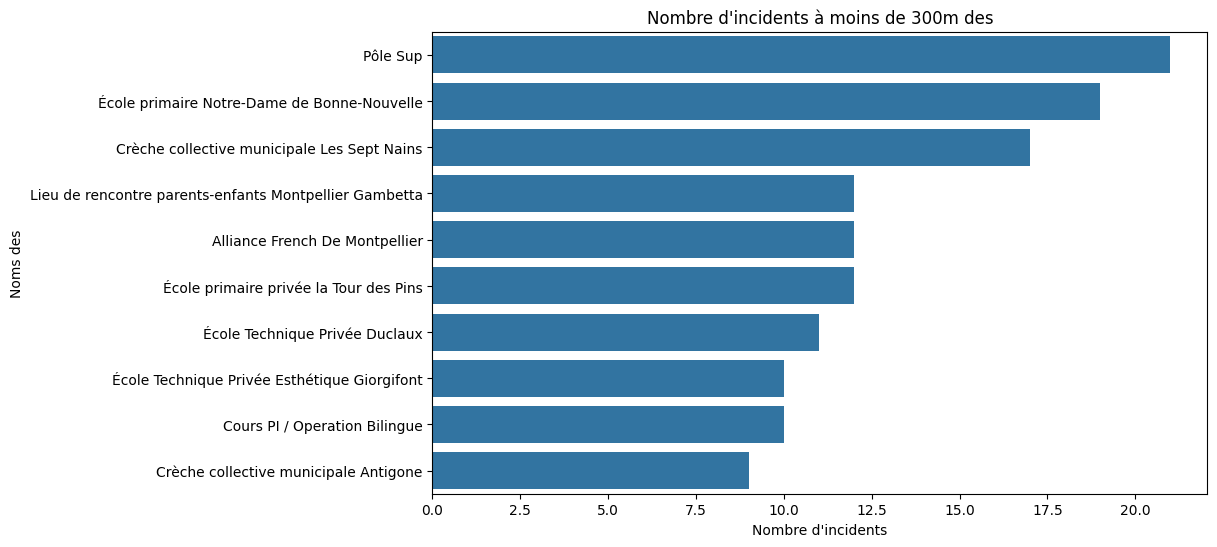

In [15]:
#Plot the number of incidents in the buffer for each POI
plt.figure(figsize=(10, 6))
sns.barplot(x='incidents_in_buffer', y='name', data=df_poi.head(10))
plt.title(f'Nombre d\'incidents à moins de {BUFFER_SIZE}m des')
plt.xlabel('Nombre d\'incidents')
plt.ylabel(f'Noms des')
plt.show()

In [16]:
#Analising the comments and explanations of the incidents
df_incidents['comment'].fillna('', inplace=True)
df_incidents['comment'] = df_incidents['comment'].str.lower()

#

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_5612\2504138621.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_incidents['comment'].fillna('', inplace=True)
